In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
from scipy.stats import linregress
import numpy as np

In [3]:
def generate_date_range(start_date, end_date):    
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_list = []
    current = start
    while current <= end:
        date_list.append(current.strftime('%Y-%m-%d'))
        current += timedelta(days=1)
    return date_list


# 使用示例（假设raw_df为原始数据）：
# '2019-12-01'
date_list = generate_date_range('2025-01-01', '2025-01-02')
# print(date_list)
raw_df = []
for date in date_list:
    raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/daily/trades/ETHUSDT/ETHUSDT-trades-{date}.zip'))
    # raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/tardis/orderbook/ETHUSDT/binance_book_snapshot_5_{date}_ETHUSDT.csv.gz'))

raw_df = pd.concat(raw_df)
print(raw_df.head())
# print(raw_df.tail())

           id    price    qty    quote_qty           time  is_buyer_maker
0  4936628773  3336.58  6.583  21964.70614  1735689605058           False
1  4936628774  3336.57  0.033    110.10681  1735689605064            True
2  4936628775  3336.58  1.135   3787.01830  1735689605072           False
3  4936628776  3336.57  0.460   1534.82220  1735689605079            True
4  4936628777  3336.57  0.231    770.74767  1735689605079            True


In [10]:
def build_dollar_bars(
    trades: pd.DataFrame,
    dollar_threshold: float,
) -> pd.DataFrame:
    """
    基于逐笔成交数据生成 dollar bars 的轴。

    trades 列要求：['time','id','price','qty','quote_qty','is_buyer_maker']
    - time: int|datetime
    - quote_qty: 成交额（价格×数量），若缺失则用 price*qty 代替
    - is_buyer_maker: 市价方向判定（True 表示成交对手为挂单买方 ⇒ 主动卖）

    返回：bar 级 DataFrame，包含每根 bar 的起止时间、OHLC、成交量/额等。
    """
    df = trades.copy()
    # df['time'] = _ensure_datetime(df['time'])
    # df['time'] = pd.to_datetime(df['time'], unit='us') 
    df['time'] = pd.to_datetime(df['time'], unit='ms') 
    df = df.sort_values('time').reset_index(drop=True)

    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']

    # 成交方向：taker 买为 +1，taker 卖为 -1
    # is_buyer_maker == True 表示成交对手是做市买方 ⇒ 主动方为卖
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)

    # 累计成交额切 bar
    cum_quote = 0.0
    current_bar_id = 0
    bar_ids: List[int] = []
    bar_starts: List[pd.Timestamp] = []
    bar_ends: List[pd.Timestamp] = []
    bar_open: List[float] = []
    bar_high: List[float] = []
    bar_low: List[float] = []
    bar_close: List[float] = []
    bar_volume: List[float] = []
    bar_quote: List[float] = []
    bar_buy_volume: List[float] = []
    bar_sell_volume: List[float] = []

    # 当前 bar 的累计
    start_idx = 0
    acc_volume = 0.0
    acc_quote = 0.0
    acc_buy = 0.0
    acc_sell = 0.0

    for i, row in df.iterrows():
        price = float(row['price'])
        qty = float(row['qty'])
        q = float(row['quote_qty'])
        sign = int(row['trade_sign'])
        cum_quote += q
        acc_volume += qty
        acc_quote += q
        if sign > 0:
            acc_buy += qty
        else:
            acc_sell += qty

        # 初始化 open/high/low
        if i == start_idx:
            o = price
            h = price
            l = price
        else:
            o = bar_open[-1] if bar_open else price
            h = max(bar_high[-1], price) if bar_high else price
            l = min(bar_low[-1], price) if bar_low else price

        # 达到阈值则切 bar（包含当前成交）
        if cum_quote >= dollar_threshold:
            segment = df.iloc[start_idx:i+1]
            bar_ids.append(current_bar_id)
            bar_starts.append(segment['time'].iloc[0])
            bar_ends.append(segment['time'].iloc[-1])
            bar_open.append(segment['price'].iloc[0])
            bar_high.append(segment['price'].max())
            bar_low.append(segment['price'].min())
            bar_close.append(segment['price'].iloc[-1])
            bar_volume.append(segment['qty'].sum())
            bar_quote.append(segment['quote_qty'].sum())
            bar_buy_volume.append((segment.loc[segment['trade_sign']>0,'qty']).sum())
            bar_sell_volume.append((segment.loc[segment['trade_sign']<0,'qty']).sum())

            # 重置
            cum_quote = 0.0
            start_idx = i + 1
            current_bar_id += 1
            acc_volume = 0.0
            acc_quote = 0.0
            acc_buy = 0.0
            acc_sell = 0.0

    bars = pd.DataFrame({
        'bar_id': bar_ids,
        'start_time': bar_starts,
        'end_time': bar_ends,
        'open': bar_open,
        'high': bar_high,
        'low': bar_low,
        'close': bar_close,
        'volume': bar_volume,
        'dollar_value': bar_quote,
        'buy_volume': bar_buy_volume,
        'sell_volume': bar_sell_volume,
    })
    return bars

In [11]:
dollar_bar = build_dollar_bars(raw_df, 10000 * 5000)

In [12]:
dollar_bar

,bar_id,start_time,end_time,open,high,low,close,volume,dollar_value,buy_volume,sell_volume
0,0,2025-01-01 00:00:05.058,2025-01-01 00:17:03.967,3336.58,3351.22,3334.76,3349.54,14956.736,5.000000e+07,9436.076,5520.660
1,1,2025-01-01 00:17:03.968,2025-01-01 00:31:29.708,3349.44,3354.04,3345.99,3353.63,14924.990,5.000219e+07,9708.394,5216.596
2,2,2025-01-01 00:31:29.708,2025-01-01 00:34:20.959,3353.63,3358.52,3353.09,3354.92,14906.376,5.001613e+07,8994.218,5912.158
3,3,2025-01-01 00:34:20.959,2025-01-01 00:52:58.834,3354.92,3360.47,3353.11,3359.69,14895.021,5.000301e+07,8493.114,6401.907
4,4,2025-01-01 00:52:58.834,2025-01-01 01:04:11.726,3359.69,3365.32,3357.73,3358.86,14878.441,5.001391e+07,7806.788,7071.653
...,...,...,...,...,...,...,...,...,...,...,...
244,244,2025-01-02 22:23:10.914,2025-01-02 22:23:27.494,3430.00,3430.00,3420.00,3426.90,14622.994,5.005885e+07,3844.758,10778.236
245,245,2025-01-02 22:23:27.494,2025-01-02 22:33:16.526,3426.90,3438.17,3424.65,3438.17,14569.998,5.000123e+07,8953.209,5616.789
246,246,2025-01-02 22:33:16.526,2025-01-02 22:50:28.182,3438.17,3443.55,3431.50,3439.44,14545.771,5.000735e+07,9186.230,5359.541
247,247,2025-01-02 22:50:28.218,2025-01-02 23:15:21.318,3439.44,3445.00,3437.00,3441.15,14529.706,5.000094e+07,7224.782,7304.924


<Axes: >

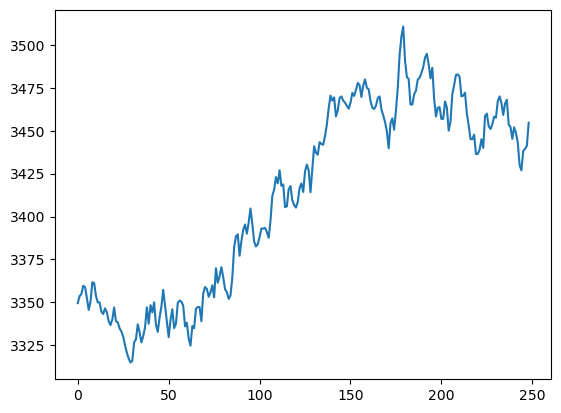

In [13]:
dollar_bar.close.plot()